In [49]:
%matplotlib inline
import torch
from torch import nn
import d2l_torch as d2l
import logging
import datetime
import importlib
import rnn_base
import os
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.optim as optim
import sys
import random
import numpy as np

import pandas as pd
import os
from gensim.models import word2vec
import torch
from torch.utils import data
from torch import nn
from gensim.models import Word2Vec

importlib.reload(rnn_base)


<module 'rnn_base' from 'C:\\Users\\rongjoker\\PycharmProjects\\ephemeralP\\pt\\rnn_base.py'>

In [2]:
print('loading dataset imdb start: ', datetime.datetime.now())
batch_size = 128
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)
print('loading dataset imdb end:', datetime.datetime.now())

loading dataset imdb start:  2023-10-29 10:47:18.515661
loading dataset imdb end: 2023-10-29 10:51:18.668361


In [10]:
for i, (features, labels) in enumerate(train_iter):
    print(len(features[0]))
    print(labels)
    break

500
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0])


In [11]:
home_dir = '../data/kaggle_bag/'
path_prefix = "../data/kaggle_bag/save/"

In [15]:

for dirname, _, filenames in os.walk(home_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/kaggle_bag/labeledTrainData.tsv.zip
../data/kaggle_bag/sampleSubmission.csv
../data/kaggle_bag/testData.tsv.zip
../data/kaggle_bag/unlabeledTrainData.tsv.zip
../data/kaggle_bag/word2vec-nlp-tutorial.zip
../data/kaggle_bag/save\0.48046875_best_acc.txt
../data/kaggle_bag/save\0.4828125_best_acc.txt
../data/kaggle_bag/save\0.4986328125_best_acc.txt
../data/kaggle_bag/save\0.50078125_best_acc.txt
../data/kaggle_bag/save\0.501171875_best_acc.txt
../data/kaggle_bag/save\0.5013671875_best_acc.txt
../data/kaggle_bag/save\0.52890625_best_acc.txt
../data/kaggle_bag/save\cifar_10.pth
../data/kaggle_bag/save\cifar_5.pth
../data/kaggle_bag/save\ckpt.model
../data/kaggle_bag/save\train_detail_10 - 副本.csv
../data/kaggle_bag/save\train_detail_10.csv
../data/kaggle_bag/save\train_detail_5.csv
../data/kaggle_bag/save\w2v_all.model
../data/kaggle_bag/save\w2v_all.model.syn1neg.npy
../data/kaggle_bag/save\w2v_all.model.wv.vectors.npy


In [21]:
df_testData = pd.read_csv(os.path.join(home_dir,'testData.tsv.zip'),sep = "\t",error_bad_lines=False)
df_testData

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...
...,...,...
24995,2155_10,"Sony Pictures Classics, I'm looking at you! So..."
24996,59_10,I always felt that Ms. Merkerson had never got...
24997,2531_1,I was so disappointed in this movie. I am very...
24998,7772_8,"From the opening sequence, filled with black a..."


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


In [100]:
def load_data_imdb(batch_size, num_steps=500):
    df_labeledTrainData = pd.read_csv(os.path.join(home_dir,'labeledTrainData.tsv.zip'),sep = "\t",error_bad_lines=False)
    train_x, train_y = list(df_labeledTrainData['review']), list(df_labeledTrainData['sentiment'])
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    train_slices = random.sample(list(range(n_train)), 20000)
    test_slices = list(set(range(n_train)) - set(train_slices))
    
    train_data = (train_x[train_slices], list(train_y[train_slices]))
    test_data = (train_x[test_slices], list(train_y[test_slices]))
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1], dtype=torch.long)),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1], dtype=torch.long)),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [111]:
def rnn_train(glove_embedding, train_iter, test_iter,vocab, lr, epochs):
    model_path = os.path.join(path_prefix, 'cifar_%s.pth' % epochs)
    def init_weights(module):
        if type(module) == nn.Linear:
            nn.init.xavier_uniform_(module.weight)
        if type(module) == nn.LSTM:
            for param in module._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(module._parameters[param])

    embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
    net = rnn_base.BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
    net.apply(init_weights)
    # Loading Pretrained Word Vectors
    # glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
    embeds = glove_embedding[vocab.idx_to_token]
    print('embeds.shape:', embeds.shape)
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction="none")

    net.embedding.weight.data.copy_(embeds)
    net.embedding.weight.requires_grad = False

    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, epochs, devices)
    torch.save(net.state_dict(), model_path)

In [109]:
batch_size = 128
train_iter, test_iter, vocab = load_data_imdb(batch_size)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [102]:
for i,(x,y) in enumerate(train_iter):
    print(y)
    print(y.to(torch.int64))
    break

tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0])


loss 0.446, train acc 0.804, test acc 0.799
3600.3 examples/sec on [device(type='cuda', index=0)]


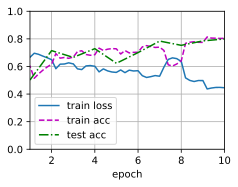

In [112]:
# lr, num_epochs = 0.01, 5
EPOCHS = 10
LR = 0.001

rnn_train(glove_embedding, train_iter, test_iter, vocab, LR, EPOCHS)

In [43]:
def cnn_train(lr=0.001, epochs=5):
    def init_weights(m):
        if type(m) in (nn.Linear, nn.Conv1d):
            nn.init.xavier_uniform_(m.weight)

    embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
    devices = d2l.try_all_gpus()
    net = rnn_base.TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
    net.apply(init_weights)
    # Loading Pretrained Word Vectors
    glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
    embeds = glove_embedding[vocab.idx_to_token]
    print('embeds.shape:', embeds.shape)

    net.embedding.weight.data.copy_(embeds)
    net.embedding.weight.requires_grad = False

    # lr, num_epochs = 0.01, 5
    # lr, num_epochs = 0.001, 5
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction="none")
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, epochs, devices)
    torch.save(net.state_dict(), 'model/sentiment_cnn.pth')

loss 0.119, train acc 0.956, test acc 0.854
8353.0 examples/sec on [device(type='cuda', index=0)]


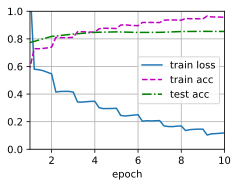

In [45]:
cnn_train(epochs=10)

In [40]:
def lstm_infer(sequence):
    print(sequence)
    embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
    model = rnn_base.BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
    model.load_state_dict(torch.load('model/sentiment_lstm.pth'))
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    print(sequence.shape)
    print(sequence.reshape(1, -1).shape)
    label = torch.argmax(model(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [8]:
def cnn_infer(sequence):
    print(sequence)
    embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
    model = rnn_base.TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
    model.load_state_dict(torch.load('model/sentiment_cnn.pth'))
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(model(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [30]:
print(lstm_infer('Exceptional storytelling and Genius Cinametography'))

Exceptional storytelling and Genius Cinametography
positive


In [31]:
print(lstm_infer('this movie is so bad'))

this movie is so bad
negative


In [28]:
print(lstm_infer("I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by "
                 "years.Oppenheimer is - with no doubt-going to be one of the best movies in the history. Amazing "
                 "cinematography, Exceptional acting and terrifying Soundtracks.All the cast are great from cilian "
                 "Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally "
                 "rami malik who has small scenes but you will never forget them.I didn't watch it in Imax as i "
                 "couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.Don't waste any "
                 "time, book your ticket and Go watch it.. NOW."))

I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by years.Oppenheimer is - with no doubt-going to be one of the best movies in the history. Amazing cinematography, Exceptional acting and terrifying Soundtracks.All the cast are great from cilian Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally rami malik who has small scenes but you will never forget them.I didn't watch it in Imax as i couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.Don't waste any time, book your ticket and Go watch it.. NOW.
positive


In [29]:
print(lstm_infer('Anything that Nolan is involved in, I will go and see, the track record is enough to get me through the doors and on that seat.'))

Anything that Nolan is involved in, I will go and see, the track record is enough to get me through the doors and on that seat.
positive


In [9]:
print(cnn_infer("I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by "
                "years.Oppenheimer is - with no doubt-going to be one of the best movies in the history. Amazing "
                "cinematography, Exceptional acting and terrifying Soundtracks.All the cast are great from cilian "
                "Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally "
                "rami malik who has small scenes but you will never forget them.I didn't watch it in Imax as i "
                "couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.Don't waste any "
                "time, book your ticket and Go watch it.. NOW."))

I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by years.Oppenheimer is - with no doubt-going to be one of the best movies in the history. Amazing cinematography, Exceptional acting and terrifying Soundtracks.All the cast are great from cilian Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally rami malik who has small scenes but you will never forget them.I didn't watch it in Imax as i couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.Don't waste any time, book your ticket and Go watch it.. NOW.
positive


In [10]:
print(cnn_infer('Exceptional storytelling and Genius Cinametography'))

Exceptional storytelling and Genius Cinametography
positive


In [48]:
print(cnn_infer('this movie is so bad'))

this movie is so bad
pool:AdaptiveMaxPool1d
negative


In [34]:
print(cnn_infer('Anything that Nolan is involved in, I will go and see, the track record is enough to get me through the doors and on that seat.'))

Anything that Nolan is involved in, I will go and see, the track record is enough to get me through the doors and on that seat.
positive


In [46]:
print(cnn_infer("Whiplash is a terrific film...no doubt about that. Normally, I'd spend several paragraphs talking about how great it is except that I am the 572nd review and many people have already gone on and on about what a terrific film it is....so what can I add?! It's the 40th highest rated film on IMDb after all!"))

Whiplash is a terrific film...no doubt about that. Normally, I'd spend several paragraphs talking about how great it is except that I am the 572nd review and many people have already gone on and on about what a terrific film it is....so what can I add?! It's the 40th highest rated film on IMDb after all!
pool:AdaptiveMaxPool1d
positive


In [47]:
print(cnn_infer('This movie was far better than the trailer made it look.'))

This movie was far better than the trailer made it look.
pool:AdaptiveMaxPool1d
positive
